Update 04/10/2023: to pair clone stamped images and beta values.

Processing image data from .mat files into npz files, saving final data in non-shuffled concatinated sets of two of low and high resolution images from all stacks.

Preprocessing images into PATCH_SIZE patches with OVERLAP.

Performing percentage normalization, illumination correction (TO DO), patchifying with or without overlap (all optional)

Saving into npz file containing: single npz file (mode 0), train-test (mode 1, stacks selection is manual), train-test-blind test (mode 2) (TODO mode 2).

Read all types NADH FAD SHG  **(*TODO*)**

.mat file format: variable 'u' for NADH (to change), [height, width, depth]

=========================
Last updated: Jan 04
Change:
- Implement multiple saving mode
- Only do percentage normalization
- Reimplemented patchifying
- code clean up




In [ ]:
# !pip install tifffile
# !pip install sklearn
# !pip install scikit-image

In [ ]:
# importing dependencies
import IPython.display as ipd
import numpy as np
import sklearn
import sklearn.model_selection
import skimage
import math
import numpy as np
from sklearn import preprocessing
import psutil
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import time
import cv2

In [ ]:
# Open drive dynamically; prefer drives that have 'drive' in their name.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FUNCTIONS

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def create_patches3D(img, patch_shape, slide): #BROKEN, achived
  # returns stack of patches and number of patches
  patch_img = skimage.util.view_as_windows(img, (patch_shape,patch_shape), step=patch_shape-slide)
  # # stacking patches
  # patch = np.zeros((patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape))
  # # creating 3D array by stacking patches by rows
  # for row in range(patch_img.shape[0]):
  #     start = row*patch_img.shape[1]
  #     end = row*patch_img.shape[1]+patch_img.shape[1]
  #     patch[row*patch_img.shape[1]:row*patch_img.shape[1]+patch_img.shape[1],:,:] = patch_img[row, :, :,:]
  patch = patch_img.reshape(patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape) # more time efficient
  return patch

def create_patches(img, patch_shape, slide):
  # returns stack of patches
  patch_img = skimage.util.view_as_windows(img, (patch_shape,patch_shape), step=patch_shape-slide)
  patch = patch_img.reshape(patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape) # more time efficient
  return patch

def merge_patches(img, patch_shape, slide):
  #  merging patches
  row_len = int(math.sqrt(img.shape[0]))
  patches = np.zeros((row_len,row_len,patch_shape,patch_shape))
  print(patches.shape)
  for r in range(row_len):
      patches[r,:,:,:] = img[r*row_len:r*row_len+row_len,:,:]
  plt.figure(5)
  plt.imshow(patches[1,1,:,:])
  return revert_img(patches,patch_shape, slide)

def revert_img(img, patch_shape, slide):
  # reverts original image and removes overlaps by splitting overlap over 2 images
  step = int(patch_shape-slide)
  reconstructed_arr = np.zeros((1024,1024))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      start_x = int(slide/2)
      start_y = int(slide/2)
      end_x = 0
      end_y = 0
      if x == 0:
        start_x = 0
        end_x = int(slide/2)
      if y == 0:
        start_y = 0
        end_y = int(slide/2)
      if x == img.shape[0]-1: end_x = int(slide/2)
      if y == img.shape[1]-1: end_y = int(slide/2)
      x_pos, y_pos = x * step + start_x, y * step + start_y
      print(x, y, )
      reconstructed_arr[x_pos : x_pos + step + end_x, y_pos : y_pos + step + end_y] = img[x, y, start_x:start_x+step+end_x, start_y:start_y+step+end_y]
  return reconstructed_arr

def normalize(img):
  # Normalizing images between 0 and 1 and preserving distribution
  img_norm = (img - np.amin(img))/( np.amax(img)- np.amin(img))
  return img_norm

def normalize_percentile(img, pmin=2, pmax=99.9, clip = False):
  # clip: False = clip bottom, do not clip top
  eps=1e-20 # avoid zero division
  mi = np.percentile(img,pmin,axis=None,keepdims=True)
  ma = np.percentile(img,pmax,axis=None,keepdims=True)
  if clip == True: return np.clip((img - mi) / ( ma - mi + eps ), 0, 1)
  return np.clip((img - mi) / ( ma - mi + eps ),0, None)

def concatenate(A,B):
  return np.concatenate((A,B)) if len(A)>0 else B

def normalize_percentile_clip(img, bottom=0, tail=99.9):
  # normalize with clipping tail
  return normalize_percentile(img, pmin=bottom, pmax=tail, clip = True)

In [ ]:
# background illumination correction using low pass filter on time domain through Fourier transform
fil = [5,10] # try 5 and 10
blur = [5,10,20,30] # try 5,10,30,50

# background illumination correction using low pass filter on time domain through Fourier transform. Subtraction in spatial domain
def correct_illumination(img, filter_radius=0, blur=0):
  if filter_radius==0: return img
  img_fft = np.fft.fftshift(np.fft.fft2(img))
  f_shape = np.shape(img_fft)
  filter = np.zeros(f_shape,dtype=np.float64)
  center = np.array(f_shape)/2.0

  for iy in range(f_shape[0]):
    for ix in range(f_shape[1]):
        filter[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < filter_radius **2

  f_filtered = filter * img_fft
  f_filtered_shifted = np.fft.fftshift(f_filtered)
  inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
  filtered_img = inv_img
  filtered_img = filtered_img.astype(np.float64)
  if b!=0:
    filtered_img = cv2.blur(src=filtered_img, ksize=(blur,blur)) # 20 looked okay
  # not normalizing filtered image as distribution has not changed
  result = normalize_percentile_clip(img-filtered_img,bottom=0.1, tail=99.9)
  return result

In [ ]:
# PREPROCESSING
# for now we are working with full size images
def preprocess_data_BETA(ddict, key, types='NADH', process="up", perc_norm = [0,100, True]):
  data = ddict['6X'][types][key]
  labels = np.squeeze(ddict['beta'][types][key])
  return [data, labels]

# normalizing, NOT splitting into patches, and then returning data, label arrays
def preprocess_data(ddict, key, types='NADH', process="up", perc_norm = [0,100, True]):
  # getting number of input images
  len_to_allocate = np.array(ddict['25X'][types][key]).shape[2]
  # predicting number of patches
  len_to_allocate = int(len_to_allocate*((OVERLAP-IMG_SIZE) / (OVERLAP-PATCH_SIZE))**2)
  data = np.empty((len_to_allocate,PATCH_SIZE,PATCH_SIZE))
  labels = np.empty((len_to_allocate,PATCH_SIZE,PATCH_SIZE))
  num_depths = np.array(ddict['25X'][types][key]).shape[2] # number of depths
  count = 0 # keep track of patches
  # for every 2D image/every depth
  for i in range(num_depths):
      # Generating image patches with overlaps with chosen patch sizes and normalize
      if CORRECT_ILLUM:
        A = correct_illumination(normalize_percentile(ddict['25X'][types][key][:, :, i],pmin=perc_norm[0], pmax=perc_norm[1],clip = perc_norm[2]),blur=b,filter_radius=f)
        B = correct_illumination(normalize_percentile(ddict['40X'][types][key][:, :, i],pmin=perc_norm[0], pmax=perc_norm[1],clip = perc_norm[2]),blur=b,filter_radius=f)
      else:
        A = normalize_percentile(ddict['25X'][types][key][:, :, i],pmin=perc_norm[0], pmax=perc_norm[1],clip = perc_norm[2])
        B = normalize_percentile(ddict['40X'][types][key][:, :, i],pmin=perc_norm[0], pmax=perc_norm[1],clip = perc_norm[2])
      A = create_patches(A, PATCH_SIZE, OVERLAP)
      B = create_patches(B, PATCH_SIZE, OVERLAP)
      # appending, depending whether we are upscaling or downscaling
      if process=="down":
        A,B = B,A # swap
      # print(np.shape(data), ", A: ", np.shape(A))
      data[count:count+len(A),:,:] = A[:,:,:]
      labels[count:count+len(B),:,:] = B[:,:,:]
      count = count + len(B)
  return [data, labels]

In [ ]:
def plotTwo(allThree, title, hist=False, save=False, savePath = None):
  fig, ax = plt.subplots(1, 2, figsize=(20,10)) # change later
  print(np.shape(ax))
  fig.suptitle(title, fontsize=16)
  if hist:
    if np.shape(allThree[0])[0] > 1:
      raw = allThree[0].flatten()
      pred = allThree[1].flatten()
    else:
      raw = allThree[0]
      pred = allThree[1]
    ax[0].set_ylim([0, 16000])
    ax[0].hist(raw, bins=100)
    ax[1].set_ylim([0, 16000])
    ax[1].hist(pred, bins=100)
  else:
    ax[0].imshow(allThree[0])
    ax[0].axis('off')
    ax[1].imshow(allThree[1])
    ax[1].axis('off')
    # ax[0].imshow(allThree[0], cmap='gray')
    # ax[1].imshow(allThree[1], cmap='gray')

  # ax[0].set_title("Input image")
  # ax[1].set_title("GT image")
  plt.show()


# EXECUTION BELOW

In [ ]:
# Constant values
IMG_SIZE = 512
OVERLAP = 0
PATCH_SIZE = 512
CORRECT_ILLUM = False
NORM_CONFIG = [0,100,False] # percentage normalization config [pmin, pmax, clip tail?]
MODE = 0
# TRAIN_SIZE = 0.75
# VAL_SIZE = 0.15
# TEST_SIZE = 1-TRAIN_SIZE-VAL_SIZE
TYPES = ['NADH','FAD','SDG'] # up to 3 types: NADH, FAD, SDG
MAIN_PATH = r"/content/drive/MyDrive/Research and Grad/ODDET/objective_transfer"
SAVE_PATH = MAIN_PATH+"/deep_learning/npz"
NPZ_VER = "beta_restore_NADH_0410" # add version of data split of splitting
# name examples
# "norm0.1to99.9wclip_0104"

In [ ]:
# FOR NADH REALIGNED 01/17
# This cell loads data into data_dict with the following schema  {'40X':{'NADH':{}, 'FAD':{}, 'SHG':{}}, '25X':{'NADH':{}, 'FAD':{}, 'SHG':{}}}
main_path = MAIN_PATH
os.chdir(main_path+'/shifted_files/beta_labeled') # change here
data_dict = {'6X':{'NADH':{}, 'FAD':{}, 'SHG':{}}, 'beta':{'NADH':{}, 'FAD':{}, 'SHG':{}}}
files = os.listdir()
results_folders = []
key_names = [] # to contain file names (ROIs) without '.mat'

# Populating dictionary
roi_mats = [] # to contain full file names
experiment_files = os.listdir()
print(experiment_files)
# appending .mat files with w40XShift to roi_mats
for experiment_file in experiment_files:
    if experiment_file.endswith('.mat'): # change HERE
        roi_mats.append(experiment_file)
print("ROIMATS: ", roi_mats)
for roi in roi_mats:
    roi_name = roi[0:-4]
    print(roi_name)
    key_names.append(roi_name)
    mat_data_struct = sio.loadmat(roi_name)
    # print(mat_data_struct['a'][0,:])
    mat_data = mat_data_struct['a']
    # print(np.shape(mat_data)) #CHANGE HERE
    # print("processing: ",mat_data[0,2])
    data_dict['6X']['NADH'][roi_name] = np.array(list(map(np.float32,mat_data[1:,2]))) # clone_stamp_6x
    # print(data_dict['6X']['NADH'][roi_name].dtype)
    # print(np.shape(data_dict['6X']['NADH'][roi_name]))
    # print("processing: ",mat_data[0,5])
    data_dict['beta']['NADH'][roi_name] = np.array(list(map(np.float32,mat_data[1:,5]))) # beta_1x
    # print(np.shape(data_dict['beta']['NADH'][roi_name]))
    # print("==================================================")
    print("NOW PRINTING: ", roi_name)
    print("")


['Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 1.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 2.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 3.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 4.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 5.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 6.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 7.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 8.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 9.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 10.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 11.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 12.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 13.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 14.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 15.mat', 'Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 16.mat', 

In [ ]:
"""Load training data from file in ``.npz`` format.
    The data file is expected to have the keys:
    - ``X``    : Array of training input images.
    - ``Y``    : Array of corresponding target images.
    - ``SB``: Array of Stack Start.
    - ``SE``: Array of Stack End.
    - ``ROI_keys``: ROI Names for all stacks.
"""

if MODE == 0: #no dataset splitting
  final_data = []
  final_labels = []
  SB = [] #  Array of Stack Start.
  SE = [] # Array of Stack End.

  for key in key_names:
    [data, label] = preprocess_data_BETA(data_dict, key, types='NADH', process="up", perc_norm = NORM_CONFIG)
    print(np.shape(data), key)
    # updating arrays of stack start and end
    SB.append(SE[-1]+1 if len(SE) > 0 else 0) # next stack starts at the next position from where last stack ended
    SE.append(SB[-1]+np.shape(data)[0]-1)
    final_data = concatenate(final_data,data)
    final_labels = concatenate(final_labels,label)
  print(np.shape(final_data)," Y: ", np.shape(final_labels), " SB: ", SB, "length: ", len(SB), "; SE: ", SE,"length: ", len(SE), " keys ", key_names)
  save_name = SAVE_PATH+'/'+str(PATCH_SIZE)+"_ovlap_"+str(OVERLAP)+"_"+NPZ_VER+'.npz'
# np.savez(save_name, X=np.float32(final_data), Y=np.float32(final_labels), SB=SB, SE=SE, ROI_keys=key_names)


(42, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 1
(30, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 2
(20, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 3
(11, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 4
(13, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 5
(4, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 6
(3, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 7
(2, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 8
(2, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 9
(9, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 10
(7, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 11
(6, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 12
(24, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 13
(6, 512, 512) Colporesults _1x_6x_test_data_beta_clonestamped_IMG_ 14
(7, 512, 512) Colporesu

Minimum value: 0.0
Maximum value: 1.0


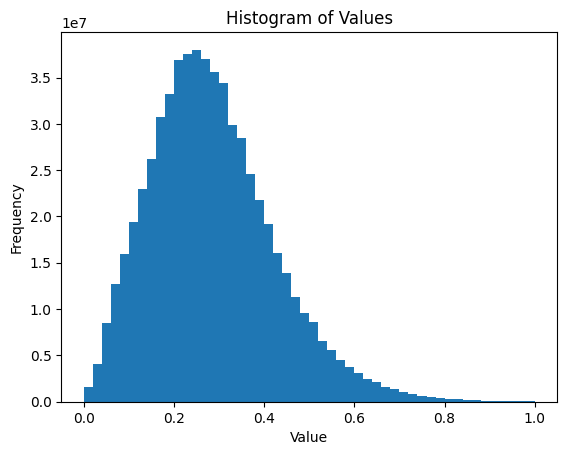

Minimum value: 0.31478208
Maximum value: 2.1755261


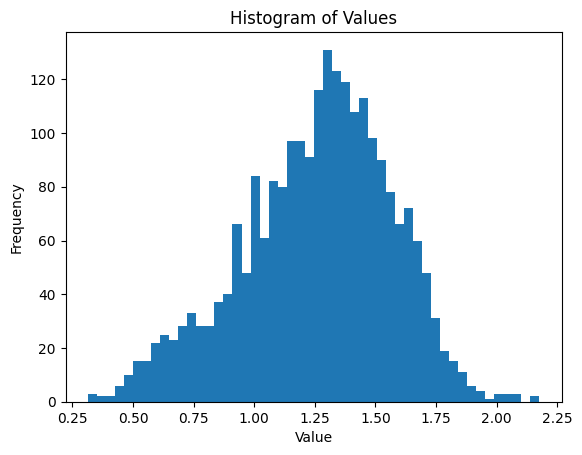

In [ ]:
# analysis
X = np.float32(final_data)
Y = np.float32(final_labels)

for i in [X,Y]:
  # Print minimum and maximum values
  print("Minimum value:", np.min(i))
  print("Maximum value:", np.max(i))

  # Create histogram of values
  values = i.flatten() # flatten array to 1D
  plt.hist(values, bins=50)
  plt.title("Histogram of Values")
  plt.xlabel("Value")
  plt.ylabel("Frequency")
  plt.show()

In [ ]:
test = [[0.8394106 ],
       [1.3363912 ],
       [1.18396   ],
       [0.6614078 ],
       [1.661835  ],
       [0.8449879 ],
       [1.3628265 ],
       [1.1608049 ],
       [1.5498537 ],
       [1.4431643 ],
       [1.3885851 ],
       [1.0100571 ],
       [0.91024405],
       [1.3628265 ],
       [1.7900832 ],
       [0.6526302 ],
       [0.8267407 ],
       [1.2802778 ],
       [1.7311691 ],
       [1.7225941 ],
       [0.9529188 ],
       [1.4103891 ],
       [1.4631234 ],
       [1.3774301 ],
       [1.2937701 ],
       [1.4530625 ],
       [1.1855187 ],
       [1.1577554 ],
       [0.7618868 ],
       [0.7815892 ],
       [0.8566577 ],
       [1.4414774 ],
       [1.3569988 ],
       [0.8186357 ],
       [2.0948608 ],
       [1.3299832 ],
       [1.4215328 ],
       [1.2518177 ],
       [1.2618711 ],
       [1.0193154 ],
       [1.4756811 ],
       [1.5353956 ],
       [0.6836866 ],
       [1.1446928 ],
       [1.5571959 ],
       [1.3331821 ],
       [1.5418775 ],
       [1.2076939 ],
       [1.1960871 ],
       [1.2096813 ]]

print(np.array(test).shape)

(50, 1)


(2343, 512, 512)
(2,)


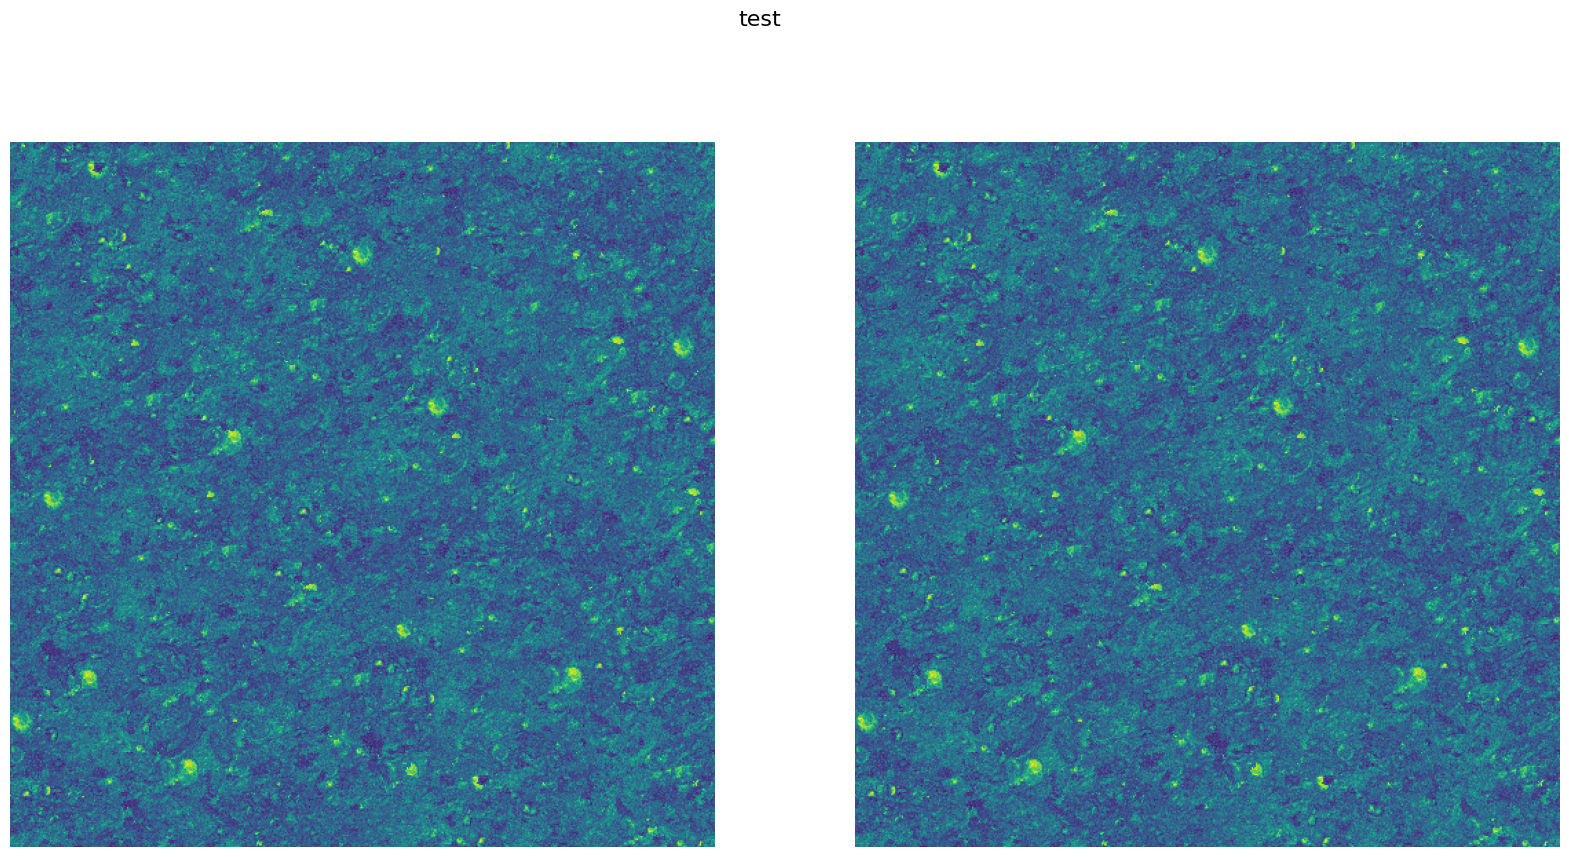

In [ ]:
print(np.shape(final_data))
plotTwo([final_data[1000],final_data[1000]],"test",hist=False)

In [ ]:
np.abs(final_data[100]-final_labels[100])

In [ ]:
print(np.shape(final_data))
plotTwo([np.absolute(final_data[100]-final_labels[100]),np.absolute(final_data[100]-final_labels[100])],"test",hist=False)

In [ ]:
print(np.shape(final_data))
plotTwo([final_data[700], final_labels[700]],"test",hist=True)

# PROTOTYPING AREA

In [ ]:
# generating 4D matrix of depth x 4 channel x size (channel = original input, normalized input, original ground truth, normalized ground truth)
# saving as mat file for each key name
from scipy.io import savemat

if CORRECT_ILLUM: #NOT FINISHED
  for b in blur:
    for f in fil:
      for key in key_names:
          print(key)
          [data, label] = preprocess_data(data_dict, key, types='NADH', process="up",pmin=0, pmax=100,clip = True,b=b,f=f)
          origin_data = np.moveaxis(data_dict['25X']['NADH'][key],-1,0) # moving depths axis to beginning
          origin_label = np.moveaxis(data_dict['40X']['NADH'][key],-1,0)
          a = [origin_data, data, origin_label, label]
          a = np.moveaxis(a, 0, 1) # moving depths axis to beginning
          print(np.shape(a))
          mdic = {"images": a}
          print("saving to: "+key+".mat")
          # plotTwo(a[1,0:2],'bruh')
          # plotTwo(a[1,0:2],'bruh',hist=True)
          # plotTwo(a[1,2:-1],'bruh')
          # plotTwo(a[1,2:-1],'bruh',hist=True)
          # savemat(key+"blur_"+str(b)+"_filter_"+str(f)+"_filtered.mat", mdic)
          print("=========saved succesfully=========")

In [ ]:
plotTwo([training_data[120],training_data_labels[120]],'training 200',hist=True)
plotTwo([training_data[120],training_data_labels[120]],'training 200')
# plotTwo([val_data[0],val_data_labels[0]],'val 20',hist=True)
# plotTwo([val_data[1],val_data_labels[1]],'val 20')

NameError: ignored

In [ ]:
# from tifffile import imsave
# # im = Image.fromarray((training_data * 255).astype(np.uint8))
# imsave('training'+str(NPZ_VER)+'.tif',training_data)
# # im = Image.fromarray((training_data_labels * 255).astype(np.uint8))
# imsave('training_label'+str(NPZ_VER)+'.tif',training_data_labels)

In [ ]:
# # saving tiff files
# from PIL import Image
# import random

# # reading data dict
# training_indices = [0, 2, 4, 5,6, 8, 9,10,11,12,7,13,14]
# training_keys = [key_names[i] for i in training_indices]

# r_data = []
# r_label = []
# for i in range(len(training_indices)):
#   if len(r_data) > 0:

#     A = np.moveaxis(data_dict['25X']['NADH'][training_keys[i]], 2, 0)
#     r_data = np.concatenate((r_data,A))
#     r_label = np.concatenate((r_label,np.moveaxis(data_dict['40X']['NADH'][training_keys[i]], 2, 0)))
#   else:
#     r_data = np.moveaxis(data_dict['25X']['NADH'][training_keys[i]], 2, 0)
#     r_label = np.moveaxis(data_dict['40X']['NADH'][training_keys[i]], 2, 0)

# # im = Image.fromarray(data)
# # im.save('test.tif')
# # shuffling training data and randomly choosing 10 images
# np.random.seed(50)
# np.random.shuffle(r_data)
# np.random.seed(50)
# np.random.shuffle(r_label)
# print(np.shape(r_data))
# for i in range(0,10):
#   plotTwo([r_data[i,...],r_label[i,...]], 'val, pred, gt', hist=False)
# arr = np.arange(10)
# np.random.shuffle(arr)
# print(arr)